# Stéréovision

![Suzanne](main.png)

La stéréovision est une discipline qui s’occupe de reconstruire des informations 3D à partir d’images. Ppour que la reconstruction d’un point soit possible, il faut plusieurs images de ce point. Ces images doivent être prises de points de vue différents. L’étape clé de la reconstruction, qui pose souvent problème, est d’indentifier l’image du point à reconstruire dans chacune des vues.

## Géométrie épipolaire

La géométrie épipolaire fait intervenir deux caméras. La géométrie épipolaire décrit les propriétés géométriques entre deux vues d’une même scène et ne dépend que des paramètres intrinsèques des caméras et de leurs positions relatives. Elle fournit, en particulier, la contrainte épipolaire, qui nous sera très utile pour produire les appariements entre vues.

## La matrice fondamentale

![Géométrie épipolaire - Sanyam Kapoor](epipolar.png)

Imaginons que nous ayons deux images, droite et gauche, de l’espace monde. Prenons un point $\vec{x}$ dans l’espace image droit. Le point $\vec{X}$ de l’espace monde, dont $\vec{x}$ est l’image, peut se trouver n’importe où sur la droite passant par $\vec{x}$ et le centre optique de la caméra de droite. Nous appellerons cette droite, le rayon retro-projeté de $\vec{x}$. Notons $\vec{x}'$ l’image de $\vec{X}$ dans l’espace image gauche. Le lieu de $\vec{x}'$ est donc la droite image du rayon retro-projeté de $\vec{x}$. Cette droite est appelée ligne épipolaire et notée $\vec{l}'$. La ligne épipolaire passe par l’épipole $\vec{e}'$, image du centre optique de la caméra de droite.

En géométrie projective 2D, une droite d’équation $ax+by+c = 0$ est représentée par un vecteur à trois composantes $(a, b, c)^T$ définies à un facteur près. On a donc la relation suivante:

>Le point $\vec{x}$ appartient à la droite $\vec{l}$ si et seulement si $x^T\vec{l} = 0$.

De plus, en géométrie projective 2D, les relations remarquables suivantes sont valables:

- L’intersection de deux lignes $l$ et $l'$ est donnée par $x = l \times l'$,
- La droite passant par deux points $x$ et $x'$ est donnée par $l = x \times x'$.

Notons que le produit vectoriel peut être écrit comme un produit de matrice $x \times y = [x]_\times y$ où

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

Pour trouver l’équation de la ligne épipolaire dans l’espace image gauche, il nous suffit donc de trouver les coordonnées de deux points de cette ligne. Le premier est l’image $P'\vec{C}$ du centre optique $\vec{C}$ de la caméra de droite où $P'$ est la matrice de projection de la caméra de gauche. Le deuxième est $P'P^{+}\vec{x}$ où $P^{+}$ est la pseudo inverse de la matrice de projection $P$ de la caméra de droite. La ligne épipolaire a donc pour équation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ avec $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ est appelée matrice fondamentale.

Comme la ligne épipolaire $\vec{l}' = F\vec{x}$ est le lieu de $\vec{x}'$, $\vec{x}'$ appartient donc à $\vec{l}'$ ce qui conduit à la contrainte épipolaire :

>**La matrice fondamentale est telle que pour toute paire de points se correspondant $\vec{x} \leftrightarrow \vec{x}'$ dans les deux images, on a $\vec{x}'^{T}F\vec{x} = 0$.**

## Calcul de la matrice fondamentale

La matrice fondamentale $F$ a sept degrés de liberté. Elle possède neuf composantes mais celles-ci sont définies à un facteur d’échelle près, ce qui enlève un degré de liberté. De plus, la matrice $F$ est une matrice singulière ($det(F) = 0$) ce qui nous fait bien sept degrés de liberté. Il nous faut donc sept correspondances minimum pour calculer $F$. L’équation $x'^{T}_iFx_i = 0$ et les sept correspondances nous permettent d’écrire un système d’équations de la forme $Af = 0$, où $f$ est le vecteur qui contient les composantes de la matrice $F$. Admettons que $A$ soit une matrice 7×9 de rang 7. La solution générale de $Af = 0$ peut s’écrire $\alpha f_1 + (1−\alpha) f_2$ où $f_1$ et $f_2$ sont deux solutions particulières indépendantes de $Af = 0$. On utilise ensuite la contrainte de singularité $det(\alpha F_1 + (1 − \alpha)F_2) = 0$ pour déterminer $\alpha$. La contrainte de singularité donnant lieu à une équation du troisième degré, on pourra avoir une ou trois solutions pour $F$.

## OpenCV

En pratique vous allez utiliser la bibliothèque OpenCV. En python, vous avez accès à ses fonctions grâce au module `cv2`.

Vous pouvez trouver de l'aide concernant les fonctions de calibration et de reconstruction à la page https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Objectif

Dans le zip de l'énoncé vous trouverez deux séquences d'images prise par deux caméras pendant le balayage d'un objet par un plan laser.

![Laser](scanRight/scan0010.png)

Vous trouverez également des prises de vue d'un damier dans différentes position qui vous aideront à calibrer vos caméras.

![Damier](chessboards/c2Right.png)

Le but est de reconstruire en 3D l'objet scanné.

In [12]:
# Import des dépendances nécessaires
import cv2 
import numpy as np
import glob
from matplotlib import pyplot as plt
import os

# __________________________________________CALIBRATION DES CAMERAS__________________________________________

# On définit le chessboard
# Chessboard dimensions
number_of_squares_X = 8 # Nombre de cases du chessboard le long de l'axe x
number_of_squares_Y = 8  # Nombre de cases du chessboard le long de l'axe y
nX = number_of_squares_X - 1 # Nombre de coins intérieurs le long de l'axe x
nY = number_of_squares_Y - 1 # Nombre de coins intérieurs le long de l'axe y

# On fait une boucle  for pour parcourir toutes les images du chessboard (++ sélection des images)
directory = "chessboards/test"
result_directory = "chessboards/result/"

# Prépare object points, comme (0,0,0), (1,0,0), (2,0,0) ...., (6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Tableaux pour stocker les points de l'objet et les points de l'image de toutes les images.
objpoints = [] # 3d point dans le monde réel
imgpoints = [] # 2d points dans le plan image
for filename in os.listdir(directory):
    filename = directory + "/" + filename
    print (filename)
    
    # Load une image
    image = cv2.imread(filename)
    
    # Convertir l'image en niveaux de gris (grayscale)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
 
    # Trouver les coins du chessboard
    success, corners = cv2.findChessboardCorners(gray, (nY, nX), None)
    print(success)
     
    # Si les coins sont trouvés par l'algorithme, on les dessine.
    if success == True:
        objpoints.append(objp)
    
        # On ajoute les corners à la liste
        imgpoints.append(corners)
    
        # Dessine les corners
        cv2.drawChessboardCorners(image, (nY, nX), corners, success)
    
        # On écrit les images modifiées dans un fichiers afin de les voir
        new_filename =  result_directory + filename[len(directory)+1::]    
    
        # Save la nouvelle image dans le working directory
        cv2.imwrite(new_filename, image)
print("DONE")

chessboards/test/c1Left.png
True
chessboards/test/c1Right.png
True
chessboards/test/c2Left.png
True
chessboards/test/c2Right.png
True
DONE


L'ordre de sortie des images chessboards a une importance.
C'est classé de 0 à 3 et cela servira par la suite pour Rodriguez (par exemple). 

In [13]:
# __________________________________________MATRICE DE PROJECTION__________________________________________

# On va traiter les différents corner pour créer la matrice de projection
# rvecs = vecteurs de rotation
# tvecs = vecteurs de translation
# mtx = Matrice A de la camera

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print(rvecs)
print("__________________________________________________")
print(tvecs)

# On transforme le rvecs en matrice 3x3
# Rotation matrix => Convertir un vecteur en matrice
rmatRight = cv2.Rodrigues(rvecs[3])[0] ## rvecs 3 représente c4Right
rmatLeft = cv2.Rodrigues(rvecs[2])[0] ## rvecs 2 représente c4Left
# Le 3 et le 2 correspondent aux lignes qui sont renvoyée par Rvecs et chaque ligne correspond à une image du chessboard
# Selon l'ordre dans lequel on lit les images 
print('----------')
print(cv2.Rodrigues(rvecs[3]))
print('---------')

# Full [R|t] matrix => ajout t in R
rotMatRight = np.concatenate((rmatRight,tvecs[0]), axis=1)
rotMatLeft = np.concatenate((rmatLeft,tvecs[0]), axis=1)
# Matrice caméra (A [R|t])
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight
# Trouver cx et cy pour chaque caméra
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
print("DONE")

(array([[-0.62113267],
       [-0.38483694],
       [ 1.43489051]]), array([[-0.21906374],
       [ 0.8730415 ],
       [ 0.07750422]]), array([[-0.89504247],
       [-0.62602284],
       [ 1.29733227]]), array([[-0.26008912],
       [ 0.5387221 ],
       [ 0.06292979]]))
__________________________________________________
(array([[-7.28028478],
       [ 0.83791703],
       [36.56973387]]), array([[ 9.19639401],
       [ 3.68164443],
       [35.45125416]]), array([[-8.36144765],
       [ 0.83600687],
       [37.5436231 ]]), array([[ 8.8906963 ],
       [ 3.73483814],
       [35.19391763]]))
----------
(array([[ 0.85729115, -0.12717368,  0.49887747],
       [-0.00876788,  0.96526336,  0.26113171],
       [-0.51475722, -0.22824   ,  0.8263967 ]]), array([[-0.0062238 ,  0.25311127,  0.07521827,  0.26363309,  0.25082587,
        -0.91831636, -0.01485576,  0.91975083,  0.24476964],
       [-0.50978168, -0.10913346,  0.84820912, -0.1309273 ,  0.00313787,
        -0.0159951 , -0.84677465,  0.0

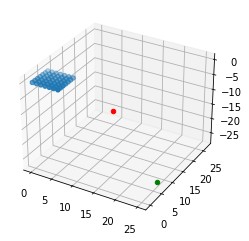

DONE


In [16]:
# Visualization
# _______________________Montrer tous les coins et le centre optique des caméras gauche et droite____________________

%matplotlib inline
def plotDotWorld():
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(objp[:,0],objp[:,1],objp[:,2])
    
    x,y,z,d = camWorldCenterLeft
    ax.scatter(x, y, z, c='r', marker='o') ## En rouge, le centre caméra gauche
    
    x2,y2,z2,d2 = camWorldCenterRight
    ax.scatter(x2, y2, z2 , c='g', marker='o') ## En vert, le centre caméra droite
    
    plt.show()
    
plotDotWorld()
print("DONE")

## Implémentation du code
 
On calcule la matrice fondamentale grâce à la formule suivante : $F = [P'\vec{C}]_\times{}P'P^{+}$ avec $\vec{C}$ le centre optique de caméra de gauche, $P'$ la matrice de projection de la caméra de doite et $P^{+}$ la pseudo inverse de la matrice de projection $P$ de la caméra de gauche.
 
Sur base des coordonnées de $\vec{x}$ dans le plan image de la camera de gauche. On calcule les coefficients des lignes epipolaires de la caméra de droite (l : ax + by + c = 0). Nous les calculons grâce à l'équation suivante : $ l^{'} = F\vec{x}$
 
Ensuite, on trace les lignes épipolaires sur le scan de droite correspondant. Nous prenons les points correspondant à l'intersection entre les lignes épipolaires et la ligne du laser. Le point d'intersection entre une ligne épipolaire et la ligne du laser nous donne les coordonnées dans le plan image de la caméra de droite de notre point $\vec{x}'$.
 
Nous calculons grâce aux matrices de projection des caméras les coordonnées monde de ces deux points. Nous calculons ensuite le rayon rétroprojeté de ces deux points. 
 
L'intersection entre ces deux rayons rétro-projetés nous donne les coordonnées du point $\vec{X}$

In [8]:
## Calcul du produit vectoriel ##
def crossMat(v):
    v = v[:,0]
    return np.array([ [ 0,-v[2],v[1] ],[ v[2],0,-v[0] ],[ -v[1],v[0],0 ] ])


# Matrice fondamentale (contient toute l'info nécessaire sur la géométrie épipolaire)
def FundMtx(camLeft,centerRight,camRight):
        return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight))

Fundamental = FundMtx(camRight,camWorldCenterLeft,camLeft)
    
# Prendre tous les pixels rouge de l'image
def getRedPixels(fname):
    img = cv2.imread(fname)
    # Access only R channel from BGR 
    red = img[:,:,2]
    # Keep only pixels between 127 and 255 in the red channel
    ret, mask = cv2.threshold(red,127,255,cv2.THRESH_TOZERO)
    return mask

# Trouve les droites épipolaires (sur l'image de la caméra de droite) pour pour tous les points rouges 
# de la ligne rouge (de la caméra de gauche), à partir de toutes les images
def findEpilines(path):
    epilines = []
    
    for l in range(26):
        # Format correct pour correspondre au nom du fichier
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        # Prendre le red mask  
        red = getRedPixels(strp)
        tempEpilines = []
        pointsLeft = [[],[],[]]
        
        # i est le numéro de la ligne
        for i, line in enumerate(red):
            for pixel in line:
                if pixel != 0:
                    pixel = 1
            try:
                # Moyenne pondérée => (0*0 + 1*0 + 2*0 + ... + 1248 * 1 + 1249 * 0) / n° of red pixels
                # Par exemple => (1261+1262+1267)/3 = 1263.33
                # donne la position de la ligne rouge sur l'axe x
                pointsLeft[0].append(np.average(range(1920), weights = line))
                pointsLeft[1].append(i) # y axis
                pointsLeft[2].append(1) # On pose s = 1 
            except:
                pass
        # A partir de la ligne rouge sur l'image de gauche, trouve la droite épipolaire correspondante sur l'image de droite.
        epilinesRight = Fundamental @ pointsLeft
        tempEpilines.append(pointsLeft)
        tempEpilines.append(epilinesRight)
        epilines.append(tempEpilines)
    return epilines


# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)] ] ]
epl = findEpilines('scanLeft/')
print("OK")

OK


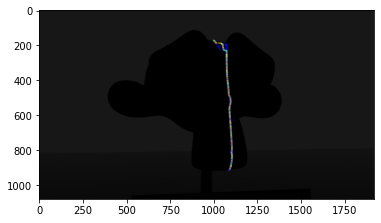

[ 6.06586737e+04  5.06774136e+04 -8.63509969e+07]
[ 6.00277481e+04  4.99027924e+04 -8.33911069e+07]
[ 5.96407436e+04  4.95871327e+04 -8.29040238e+07]
[ 5.94241774e+04  4.95921693e+04 -8.41447985e+07]
[ 5.92013366e+04  4.95853998e+04 -8.53219643e+07]
[ 5.89753939e+04  4.95727936e+04 -8.64676824e+07]
[ 5.87509402e+04  4.95629891e+04 -8.76284964e+07]
[ 5.85190996e+04  4.95392855e+04 -8.87144239e+07]
[ 5.82754123e+04  4.94932913e+04 -8.96802529e+07]
[ 5.80273645e+04  4.94390922e+04 -9.06018762e+07]
[ 5.77914584e+04  4.94077390e+04 -9.16465885e+07]
[ 5.75017598e+04  4.92751699e+04 -9.21459669e+07]
[ 5.72783168e+04  4.92672672e+04 -9.33170271e+07]
[ 5.70985066e+04  4.93414638e+04 -9.49304246e+07]
[ 5.68700530e+04  4.93241333e+04 -9.60506894e+07]
[ 5.66320550e+04  4.92888439e+04 -9.70741944e+07]
[ 5.63960407e+04  4.92572870e+04 -9.81178097e+07]
[ 5.61608528e+04  4.92272853e+04 -9.91698039e+07]
[ 5.59261119e+04  4.91981244e+04 -1.00226328e+08]
[ 5.56917100e+04  4.91696016e+04 -1.01286291e+08]


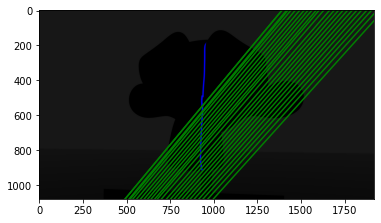

DONE


In [9]:
# Visualization
# _______________________________________________LIGNE EPIPOLAIRE____________________________________________

def drawAvgPoint(fname,EplLeft):
    img = cv2.imread(fname)
    for i in range(len(EplLeft[0])):
        color = tuple(np.random.randint(0,255,3).tolist())
        img = cv2.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),5,color,-1)
    plt.imshow(img)
    plt.show()

# Equation d'une ligne => renvoie une valeur pour y pour un x et des coefficients donnés
def lineY(coefs,x):
    a,b,c = coefs
    return-(c+a*x)/b


def drawEpl(fname,EplRight):
    img = cv2.imread(fname)
    coef, length = EplRight.shape
    for i in range(0,length,30):
        # Print a, b and c de la droite épipilaire
        print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'g')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0012.png',epl[12][0])
drawEpl('scanRight/scan0012.png',epl[12][1])
print("DONE")

In [10]:
# Obtenir la position x du point rouge de chaque ligne de pixels (un seul point par ligne, d'où la position moyenne)
def getRedPixelsAvg(fname):
    red = getRedPixels(fname)
    redPoints = [[],[],[]]

    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            # Pareil que dans find epilines
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
    return redPoints

# Trouver les points rouges qui sont sur la ligne épipolaire, pour chaque image.
def getPointsRightFromEpl(path,EplRight):
    points = []
    for l in range(26):
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        redPoints = getRedPixelsAvg(strp)
        scan = cv2.imread(strp)

        pointsRight = [[],[],[]]
        eplImg = EplRight[l][1] # Garde seulement la droite épipolaire et pas les points rouges (EplRight[l][0])
        print(strp)
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i]) # Position moyenne
                y = int(lineY(eplImg[:,i],x)) # Utilisation de y = (-ax+c)/b pour trouver la position y
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
                
                # color = tuple(np.random.randint(0,255,3).tolist())
                # scan = cv2.circle(scan,(x,y),5,color,-1)
            except:
                pass
        points.append(pointsRight)
        # plt.imshow(scan)
        # plt.show()
    return points


pointsRight = getPointsRightFromEpl('scanRight/scan',epl)
print("DONE")

scanRight/scan0000.png
scanRight/scan0001.png
scanRight/scan0002.png
scanRight/scan0003.png
scanRight/scan0004.png
scanRight/scan0005.png
scanRight/scan0006.png
scanRight/scan0007.png
scanRight/scan0008.png
scanRight/scan0009.png
scanRight/scan0010.png
scanRight/scan0011.png
scanRight/scan0012.png
scanRight/scan0013.png
scanRight/scan0014.png
scanRight/scan0015.png
scanRight/scan0016.png
scanRight/scan0017.png
scanRight/scan0018.png
scanRight/scan0019.png
scanRight/scan0020.png
scanRight/scan0021.png
scanRight/scan0022.png
scanRight/scan0023.png
scanRight/scan0024.png
scanRight/scan0025.png
DONE


In [11]:
# __________________________________________IMPRESSION FINALE DE LA FIGURE 3D_____________________________________________

%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from mathutils import geometry as pygeo
from mathutils import Vector
import json


def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))


def getIntersection(pointsLeft,pointsRight):
    
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # Obtenir les coordonnées 3D monde/objet de tous les points
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # Points caractéristiques des lignes rétro-projetées
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    
    # Intersection entre deux lignes rétroprojetées = point du monde réel
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)

def getObjectPoint():
    point = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # Calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                # print(intersection)
                for inter in intersection:
                    inter *= 1000
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass
    return np.array(point)
        

def drawPointObject(points):
    figure = plt.figure()
    ax = Axes3D(figure, auto_add_to_figure=False) # auto_add_to_figure=False pour ne plus avoir d'erreur
    figure.add_axes(ax) # Pour ne plus avoir d'erreur
    
    ax.scatter3D(points[0,:],points[1,:],points[2,:],c='blue',marker='.')     
        
    ax.view_init(-289,-80)
    plt.axis('off')
    plt.show()
    

def drawSurfaceObject(points):
    figure = plt.figure()
    ax = Axes3D(figure, auto_add_to_figure=False) # auto_add_to_figure=False pour ne plus avoir d'erreur
    figure.add_axes(ax) # Pour ne plus avoir d'erreur
    ax.plot_trisurf(points[0,:],points[1,:],points[2,:])     

    ax.view_init(-289,-80)
    plt.axis('off')
    plt.show()
    
    
def pointToJson(point):
    data = {'x':point[0,:].tolist(),'y':point[1,:].tolist(),'z':point[2,:].tolist()}
    with open('point.txt','+w') as file:
        json.dump(data,file)


point = getObjectPoint()
drawSurfaceObject(point)
drawPointObject(point)
pointToJson(point)
print("DONE DONE DONE")

ModuleNotFoundError: No module named 'mathutils'